**Aqora** helps you manage your development environment! You can click `Run All` above and select `Python Environments > .venv` when picking a kernel.

To add dependencies you can open a new Terminal with `Terminal > New Terminal` and run `aqora add <dependency name>`

In [1]:
import cv2
from matplotlib import image
from matplotlib import pyplot as plt
from typing import Tuple, List
import cv2 as cv
import numpy as np
from scipy.optimize import minimize

# Ideal Court

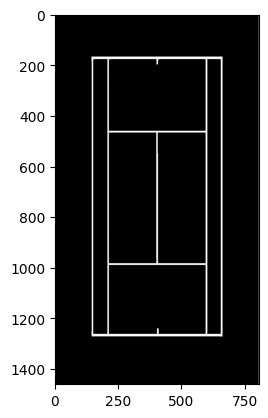

In [2]:
ideal_court = image.imread("ideal_court.png", format=0)  # The zero makes it grayscale
plt.imshow(ideal_court, cmap="gray")

# Image loading

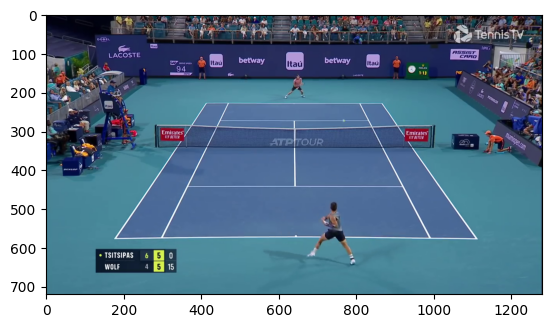

In [3]:
# id = "E3iMgC0-Hxw_250"
id = "0Ke1MYdxsgg_2000"
img = image.imread(f"data/{id}.png")
plt.imshow(img)

# Apply Homographic transform

In [4]:
def apply_homography(
        image: cv.typing.MatLike,
        theta: List[List[float]],
        target_shape: Tuple[float] | None = None
) -> cv.typing.MatLike:
    transformation_matrix = cv2.getPerspectiveTransform(
        src=np.array([[150, 590], [250, 200], [880, 200], [1150, 590]], dtype=np.float32),
        dst=np.array(theta, dtype=np.float32),
    )
    return cv.warpPerspective(
        src=image,
        M=transformation_matrix,
        dsize=target_shape if target_shape is not None else image.shape[:2][::-1],
    )
    # src: coordinates in the source image


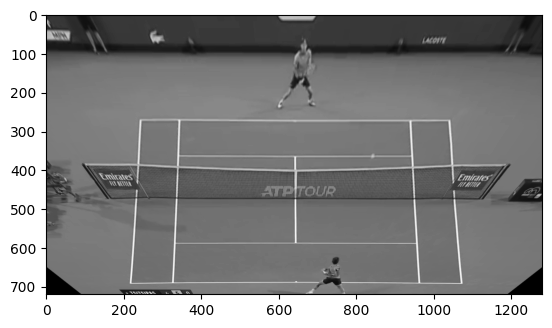

In [5]:
plt.imshow(
    np.mean(
        apply_homography(
            image=img,
            theta=[[200, 700], [-100, 200], [1100, 200], [1100, 700]]
        ),
        axis=2
    ),
    cmap="gray"
)

# Remove shadows

1. Sample the most common colour
2. Apply the mask for equality with the mode
3. Calculate the boxFilter with $7 \times 7$
4. Apply the filter for at least 4 common codes, and the center pixel is not in the mode

## Auxiliary

In [6]:
def show_img_compar(img_1, img_2):
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off')  #hide the axis
    ax[1].axis('off')
    f.tight_layout()
    plt.show()

In [7]:
def get_mode_colour(image: cv.typing.MatLike) -> np.array:
    img_temp = img.copy()
    unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
    return unique[np.argmax(counts)]
    # img_temp[:, :, 0], img_temp[:, :, 1], img_temp[:, :, 2] = unique[np.argmax(counts)]
    # 
    # show_img_compar(img, img_temp)

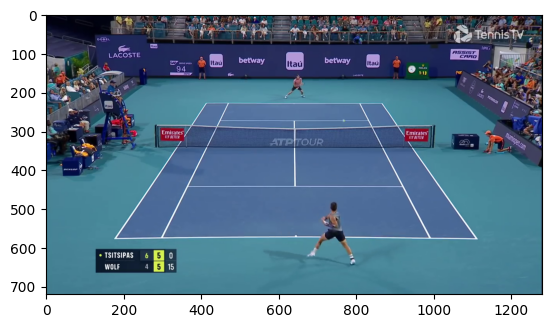

In [8]:
plt.imshow(img)

In [9]:
mode_colour = get_mode_colour(image=img)
(img == mode_colour).shape

(720, 1280, 3)

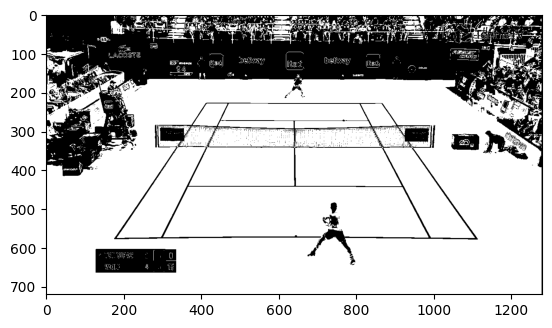

In [10]:
# Get colour detection
filtered_image = (np.sum(np.abs(img[:, :, 0:3] - mode_colour) ** 2, axis=2) < .1).astype(int)
plt.imshow(filtered_image, cmap="gray")

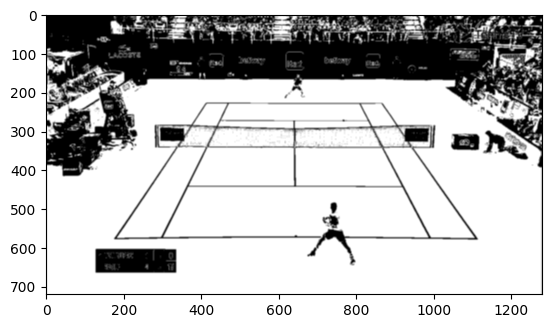

In [11]:
# boxFilter
box_filtered = cv.boxFilter(filtered_image.astype(float), ddepth=-1, ksize=(5, 5), normalize=True)
plt.imshow(box_filtered, cmap="gray")

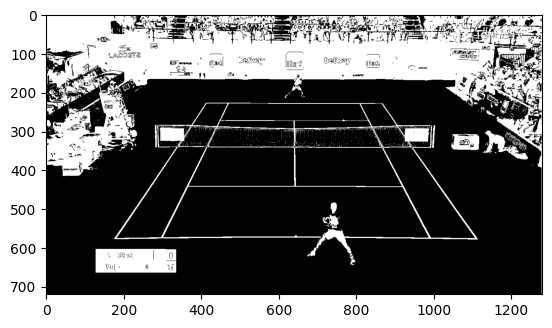

In [12]:
# Shadowless image
custom_filter = np.vectorize(lambda x, y: x < .16 or y == 0)
final_image = custom_filter(box_filtered, filtered_image).astype(int)
plt.imshow(final_image, cmap="gray")

# Jaccard Similarity

In [13]:
def jaccard_similarity(
        image: cv.typing.MatLike,
        base_img: cv.typing.MatLike = ideal_court
) -> float:
    assert image.shape == base_img.shape, f"You need to have images of equal size to use the Jaccard index ( {image.shape} != {base_img.shape})"
    # Only works for monochromatic data
    numerator = np.vectorize(lambda i, b: b == 1 and i == 1)
    denominator = np.vectorize(lambda i, b: b == 1)
    return np.divide(
        sum(sum(numerator(image, base_img))),
        sum(sum(denominator(image, base_img)))
    )

## sanity check

In [14]:
ideal_court.shape

(1461, 806)

In [15]:
jaccard_similarity(filtered_image, filtered_image)

1.0

In [16]:
jaccard_similarity(filtered_image, filtered_image[::-1])

0.662584279447961

In [17]:
# Requires resizing
# jaccard_similarity(filtered_image, ideal_court)

# Loss function

In [18]:
def loss_function(
        image: cv.typing.MatLike,
        theta: List[List[float]],
        target: cv.typing.MatLike = ideal_court
) -> float:
    transformed_image = apply_homography(
        image=filtered_image.astype(float),
        theta=theta,
        target_shape=list(target.shape)[::-1]
    ).astype(int)
    return jaccard_similarity(transformed_image, ideal_court)

In [19]:
loss_function(img, theta=[[200, 600], [200, 200], [1100, 200], [1100, 600]])

0.415948491331907

# Optimize with scipy

In [20]:
def our_minimization(
        img: cv.typing.MatLike,
        theta_0: np.array
):
    def flattened_loss(flat_theta):
        return loss_function(
            image=img,
            theta=flat_theta.reshape(4, 2),
            target=ideal_court,
        )

    return minimize(
        flattened_loss,
        x0=theta_0.flatten(),
        method="Nelder-Mead",
    )

In [ ]:
our_minimization(
    img=filtered_image,
    theta_0=np.array([[200, 600], [200, 200], [1100, 200], [1100, 600]]),
)